In [1]:
import keras

Using TensorFlow backend.


## 原始資料來源的 SQL，這是抽樣過的資料，當中也有一筆資料是修改過的，因為當天 Server 似乎出了一些問題，導至流量大符下降
```sql
SELECT 
date,count(distinct cookie_pta) as uv
from
TABLE_DATE_RANGE(XXX_Table, TIMESTAMP('2017-01-01'), CURRENT_TIMESTAMP())
group by date
order by date
``` 


date
2016-08-25    48844
2016-08-26    45711
2016-08-27    45016
2016-08-28    44743
2016-08-29    46924
Name: uv, dtype: int64


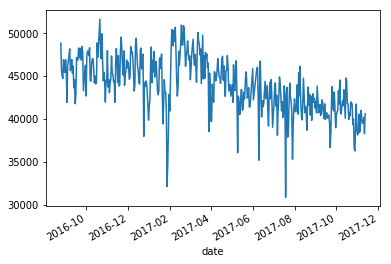

In [2]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y%m%d')


series = read_csv('./data/pixnet_uv_sample.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

## 進行 scale to 0-1 ，方便作為 input 及 output (因為 sigmoid 介於 0~1 之間)

In [3]:
from sklearn.preprocessing import scale,MinMaxScaler
scaler = MinMaxScaler()

In [4]:
x = series.values

In [5]:
x = x.reshape([x.shape[0],1])

In [6]:
scaler.fit(x)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [7]:
x_scaled = scaler.transform(x)

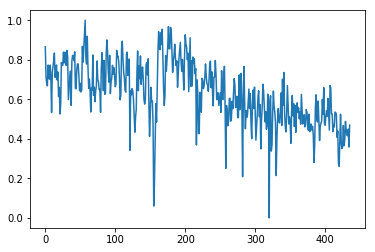

In [8]:
pyplot.plot(x_scaled)
pyplot.show()

## 產生 x,y pair 
* 舉列來說假設將 Step Size 設為 4 天，故一筆 Training Data ，為連續 4 天的流量。再來利用這４天的資料來預測第 5 天的流舉
* 綠色的部是 Training Data(前4天的資料)，藍色的部份是需要被預測的部份。示意如下圖
* <img align="left" width="50%" src="./imgs/sequence_uv.png" />

In [61]:
#往回看 30 天前的每一筆資料
step_size = 15

In [62]:
print("原始資料長度:{}".format(x_scaled.shape))

原始資料長度:(436, 1)


In [63]:
def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width) )

import numpy as np
train_x = window_stack(x_scaled, stepsize=1, width=step_size)

In [64]:
# 最後一筆資料要放棄，因為沒有未來的答案作驗證

train_x = train_x[:-1]
train_x.shape

(421, 15)

In [65]:
# 請注意千萬不將每一筆(Row) 當中的最後一天資料作為 Training Data 中的 Input Data
train_y = np.array([i for i in x_scaled[step_size:]]) 

## 確認產出來的 Training Data 沒有包含到 Testing Data

In [66]:
train_y.shape

(421, 1)

In [67]:
train_x[0]

array([ 0.86594605,  0.71476138,  0.68122376,  0.66804999,  0.77329537,
        0.71099744,  0.70202191,  0.77319886,  0.70346957,  0.53332047,
        0.73662115,  0.7644646 ,  0.7965063 ,  0.83400087,  0.71138349])

In [68]:
train_x[1]

array([ 0.71476138,  0.68122376,  0.66804999,  0.77329537,  0.71099744,
        0.70202191,  0.77319886,  0.70346957,  0.53332047,  0.73662115,
        0.7644646 ,  0.7965063 ,  0.83400087,  0.71138349,  0.73913043])

In [69]:
train_y[0]

array([ 0.73913043])

## Design Graph

In [92]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(train_x, (train_x.shape[0], step_size, 1))

In [105]:
from keras import Sequential
from keras.layers import LSTM,Dense
# create and fit the LSTM network
model = Sequential()
# input_shape(step_size,feature_dim)
model.add(LSTM(4, input_shape=(step_size,1), unroll=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## 最後30 筆資料不要看

In [106]:
validation_size = 60

In [ ]:
val_loss = []
loss = []
for _ in range(1000):
    history = model.fit(trainX[:-1*validation_size],
              train_y[:-1*validation_size],
              epochs=1,shuffle=False, 
              validation_data=(trainX[-1*validation_size:],
              train_y[-1*validation_size:]))
    
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    model.reset_states()

Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 3s 7ms/step - loss: 0.2662 - acc: 0.0028 - val_loss: 0.1139 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 613us/step - loss: 0.2146 - acc: 0.0028 - val_loss: 0.0840 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 617us/step - loss: 0.1679 - acc: 0.0028 - val_loss: 0.0587 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.1271 - acc: 0.0028 - val_loss: 0.0383 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 610us/step - loss: 0.0927 - acc: 0.0028 - val_loss: 0.0230 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [============================

361/361 [==============================] - 0s 606us/step - loss: 0.0141 - acc: 0.0028 - val_loss: 0.0096 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 600us/step - loss: 0.0140 - acc: 0.0028 - val_loss: 0.0096 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 599us/step - loss: 0.0140 - acc: 0.0028 - val_loss: 0.0095 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0140 - acc: 0.0028 - val_loss: 0.0094 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0140 - acc: 0.0028 - val_loss: 0.0093 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0140 - acc: 0.0028 - va

361/361 [==============================] - 0s 627us/step - loss: 0.0134 - acc: 0.0028 - val_loss: 0.0075 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 632us/step - loss: 0.0134 - acc: 0.0028 - val_loss: 0.0075 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 724us/step - loss: 0.0134 - acc: 0.0028 - val_loss: 0.0075 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 646us/step - loss: 0.0134 - acc: 0.0028 - val_loss: 0.0074 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 615us/step - loss: 0.0134 - acc: 0.0028 - val_loss: 0.0074 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 602us/step - loss: 0.0134 - acc: 0.0028 - va

361/361 [==============================] - 0s 613us/step - loss: 0.0132 - acc: 0.0028 - val_loss: 0.0070 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 608us/step - loss: 0.0132 - acc: 0.0028 - val_loss: 0.0070 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 603us/step - loss: 0.0131 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 618us/step - loss: 0.0131 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0131 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 615us/step - loss: 0.0131 - acc: 0.0028 - va

361/361 [==============================] - 0s 590us/step - loss: 0.0130 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 591us/step - loss: 0.0130 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0130 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 604us/step - loss: 0.0130 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0130 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 595us/step - loss: 0.0129 - acc: 0.0028 - va

361/361 [==============================] - 0s 613us/step - loss: 0.0128 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 611us/step - loss: 0.0128 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 603us/step - loss: 0.0128 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0128 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0128 - acc: 0.0028 - val_loss: 0.0069 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 615us/step - loss: 0.0128 - acc: 0.0028 - va

361/361 [==============================] - 0s 607us/step - loss: 0.0127 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 602us/step - loss: 0.0127 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 604us/step - loss: 0.0127 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0127 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0127 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 618us/step - loss: 0.0127 - acc: 0.0028 - va

361/361 [==============================] - 0s 605us/step - loss: 0.0126 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 616us/step - loss: 0.0125 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 609us/step - loss: 0.0125 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 601us/step - loss: 0.0125 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 604us/step - loss: 0.0125 - acc: 0.0028 - val_loss: 0.0068 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 614us/step - loss: 0.0125 - acc: 0.0028 - va

361/361 [==============================] - 0s 597us/step - loss: 0.0124 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 590us/step - loss: 0.0124 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 595us/step - loss: 0.0124 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0124 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 615us/step - loss: 0.0124 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 607us/step - loss: 0.0124 - acc: 0.0028 - va

361/361 [==============================] - 0s 598us/step - loss: 0.0122 - acc: 0.0028 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 601us/step - loss: 0.0122 - acc: 0.0028 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0122 - acc: 0.0028 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 594us/step - loss: 0.0122 - acc: 0.0028 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 593us/step - loss: 0.0122 - acc: 0.0028 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 602us/step - loss: 0.0122 - acc: 0.0028 - va

361/361 [==============================] - 0s 605us/step - loss: 0.0120 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0120 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 607us/step - loss: 0.0120 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 600us/step - loss: 0.0120 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 599us/step - loss: 0.0120 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0120 - acc: 0.0028 - va

361/361 [==============================] - 0s 596us/step - loss: 0.0119 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 594us/step - loss: 0.0119 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 602us/step - loss: 0.0119 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 616us/step - loss: 0.0119 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0119 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 599us/step - loss: 0.0119 - acc: 0.0028 - va

361/361 [==============================] - 0s 602us/step - loss: 0.0118 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 585us/step - loss: 0.0118 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 599us/step - loss: 0.0118 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 602us/step - loss: 0.0118 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 601us/step - loss: 0.0118 - acc: 0.0028 - val_loss: 0.0067 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 612us/step - loss: 0.0118 - acc: 0.0028 - va

361/361 [==============================] - 0s 603us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 616us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 595us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 596us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 604us/step - loss: 0.0117 - acc: 0.0028 - va

361/361 [==============================] - 0s 603us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 599us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 604us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 598us/step - loss: 0.0117 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 607us/step - loss: 0.0117 - acc: 0.0028 - va

361/361 [==============================] - 0s 603us/step - loss: 0.0116 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 605us/step - loss: 0.0116 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 603us/step - loss: 0.0116 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 597us/step - loss: 0.0116 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 601us/step - loss: 0.0116 - acc: 0.0028 - val_loss: 0.0066 - val_acc: 0.0000e+00
Train on 361 samples, validate on 60 samples
Epoch 1/1
361/361 [==============================] - 0s 600us/step - loss: 0.0116 - acc: 0.0028 - va

## 看一下 Error Rate 曲線

In [ ]:
pyplot.plot(loss)
pyplot.plot(val_loss)
pyplot.show()

# 看一下曲線擬合效果

In [ ]:
predict_y = model.predict(trainX)

In [ ]:
train_y.shape

In [ ]:
pyplot.plot(scaler.inverse_transform(predict_y))
pyplot.plot(scaler.inverse_transform(train_y))

pyplot.show()

## 來預測最後 30天資料預出來的結果

In [ ]:
predict_y = model.predict(trainX[-1*validation_size:])

In [ ]:
predict_y = scaler.inverse_transform(predict_y)

In [ ]:
predict_y.shape

In [ ]:
pyplot.plot(predict_y)
pyplot.plot(x[-1*(validation_size+1):-1])

pyplot.show()

## 心得觀察
* LSTM 可以學習到 Period Pattern 是沒有問題的，但是似乎對於大幅的震盪以目前的 Model 來說無法完全的 Catch 到，但是還是有學到漲幅的趨勢預測
* 至於 LSTM 要如何調整震盪的幅度有兩個想法可以實驗看看
 * 直接 Modified Training，將震盪幅度加大
 * 修改 Loss Function ，把平方改為 2.x 次方不知道是否有效果